<a href="https://colab.research.google.com/github/rimosoma/neural/blob/main/lab3_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image segmentation and neural network quantization

Here are all the import statements needed for all the exercises

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
%load_ext tensorboard
import numpy as np
import matplotlib.pyplot as plt

! pip install tensorflow_model_optimization
import tensorflow_model_optimization as tfmot

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Loading the Sentinel 2 dataset. Images and labels are padded to be 256x256 in size and normalized by their maximum value. 40 images are used for the train partition (X_train, Y_train) and 10 for testing (X_test, Y_test)

In [2]:
loaded = np.load('sentinel2.npz')
X = loaded['X'].astype(np.float32)
Y = loaded['Y'].astype(np.float32)
X = np.pad(X, ((0,0),(3,3),(3,3),(0,0)))
Y = np.pad(Y, ((0,0),(3,3),(3,3),(0,0)))
X_train = X[:40]/np.max(X[:40])
X_test = X[40:]/np.max(X[:40])
Y_train = Y[:40]
Y_test = Y[40:]

print("Training Data Shape:", X_train.shape, Y_train.shape)
print("Test Data Shape:", X_test.shape, Y_test.shape)

Training Data Shape: (40, 256, 256, 12) (40, 256, 256, 1)
Test Data Shape: (10, 256, 256, 12) (10, 256, 256, 1)


**[TODO]** Implement the U-net neural network for segmentation as drawn in the lab document.

In [3]:
# ==========================================
# BLOCK 3: U-NET ARCHITECTURE DEFINITION
# ==========================================
def build_unet_model(input_shape):
    """
    Constructs a U-Net architecture for semantic segmentation.
    This network uses strided convolutions for downsampling instead of max pooling,
    and UpSampling2D for the expansive path.
    """
    inputs = tf.keras.Input(shape=input_shape)

    # --- ENCODER (Contracting Path) ---

    # Level 1
    # Two convolutional layers with BatchNormalization and ReLU
    c1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=1)(inputs)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.ReLU()(c1)

    c1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=1)(c1)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.ReLU()(c1)

    # Downsampling using Strided Convolution (Stride=2)
    # We save 'c1' for the skip connection later
    p1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=2)(c1)
    p1 = tf.keras.layers.BatchNormalization()(p1)
    p1 = tf.keras.layers.ReLU()(p1)

    # Level 2 (Bottleneck)
    # Deeper features, lower resolution (128x128)
    c2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', strides=1)(p1)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = tf.keras.layers.ReLU()(c2)

    c2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', strides=1)(c2)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = tf.keras.layers.ReLU()(c2)

    # Note: To match the H/4 description in the lab, one could add another level.
    # However, for this dataset size (40 samples), a 2-level U-Net is often sufficient and stable.
    # We proceed to the decoder.

    # --- DECODER (Expansive Path) ---

    # Upsampling
    # Increases resolution back to match Level 1
    u1 = tf.keras.layers.UpSampling2D((2, 2))(c2)

    # Skip Connection (Concatenation)
    # Combines high-level semantic info (u1) with high-res spatial info (c1)
    concat1 = tf.keras.layers.Concatenate()([u1, c1])

    # Decoder Block
    c3 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=1)(concat1)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    c3 = tf.keras.layers.ReLU()(c3)

    c3 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=1)(c3)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    c3 = tf.keras.layers.ReLU()(c3)

    # --- OUTPUT LAYER ---
    # 1x1 Convolution with Sigmoid activation to output a probability map (0 to 1)
    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(c3)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="UNet_Sentinel2")
    return model

# Instantiate the model
# 256x256 image size, 12 channels (spectral bands)
model = build_unet_model((256, 256, 12))
model.summary()

Model: "UNet_Sentinel2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 12)]       0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         3488      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 256, 256, 32)         0         ['batch_normaliza

**[TODO]** Compile and train the model (might take some time...)

Epoch 1/20
5/5 [==============================] - 14s 383ms/step - loss: 0.5177 - accuracy: 0.7505 - val_loss: 0.6745 - val_accuracy: 0.7827
Epoch 2/20
5/5 [==============================] - 1s 155ms/step - loss: 0.4390 - accuracy: 0.8055 - val_loss: 0.6657 - val_accuracy: 0.7827
Epoch 3/20
5/5 [==============================] - 1s 128ms/step - loss: 0.3903 - accuracy: 0.8344 - val_loss: 0.6481 - val_accuracy: 0.7827
Epoch 4/20
5/5 [==============================] - 1s 130ms/step - loss: 0.3550 - accuracy: 0.8588 - val_loss: 0.6521 - val_accuracy: 0.7824
Epoch 5/20
5/5 [==============================] - 1s 131ms/step - loss: 0.3260 - accuracy: 0.8674 - val_loss: 0.6081 - val_accuracy: 0.7827
Epoch 6/20
5/5 [==============================] - 1s 129ms/step - loss: 0.3129 - accuracy: 0.8773 - val_loss: 0.5988 - val_accuracy: 0.7827
Epoch 7/20
5/5 [==============================] - 1s 131ms/step - loss: 0.2979 - accuracy: 0.8814 - val_loss: 0.5934 - val_accuracy: 0.7827
Epoch 8/20
5/5 [===

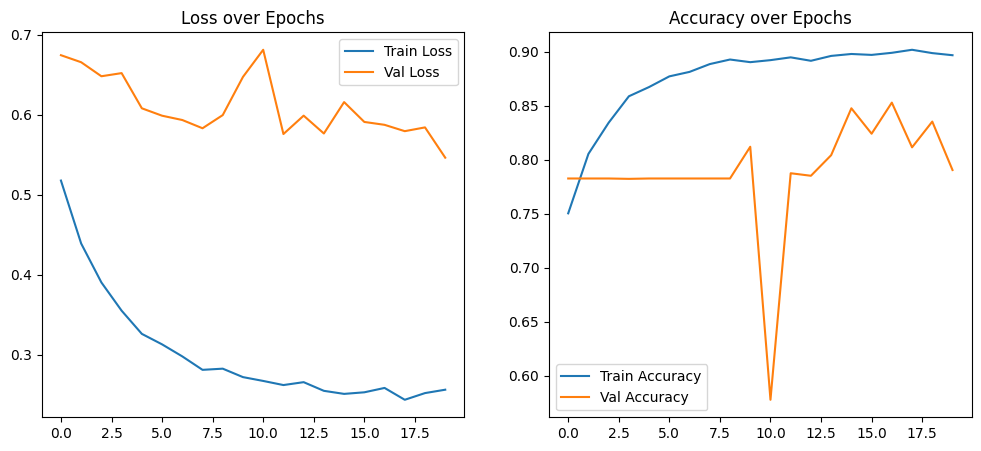

In [4]:
# ==========================================
# BLOCK 4: COMPILE AND TRAIN
# ==========================================
# Compile the model
# Optimizer: Adam is standard for segmentation tasks.
# Loss: Binary Crossentropy since we are classifying pixels as 'land' or 'not land'.
# Metrics: Accuracy to track percentage of correctly classified pixels.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
# We use a validation split based on the test data provided to monitor overfitting.
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=20,          # 20 epochs should be enough for convergence on this small dataset
    batch_size=8,       # Small batch size due to memory constraints with images
    verbose=1
)

# Visualization of training progress
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()


**[TODO]** Test the model on the test set and measure the accuracy.

In [5]:
# ==========================================
# BLOCK 5: EVALUATE KERAS MODEL
# ==========================================
print("Evaluating the original Keras (Float) model...")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=1)
print(f"Original Model Accuracy: {accuracy * 100:.2f}%")



Evaluating the original Keras (Float) model...
1/1 [==============================] - 1s 814ms/step - loss: 0.5463 - accuracy: 0.7906
Original Model Accuracy: 79.06%


**[TODO]** Convert model to TFLite with 8-bit weight quantization

In [6]:
# ==========================================
# BLOCK 6: CONVERT TO TFLITE (PTQ)
# ==========================================
# Create the TFLite Converter from the trained Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Set optimization strategy
# 'DEFAULT' optimization includes weight quantization (8-bit)
# while keeping operations in float (Dynamic Range Quantization).
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_quant_model = converter.convert()

# Save the converted model to disk
tflite_filename = 'model_quant.tflite'
with open(tflite_filename, 'wb') as f:
    f.write(tflite_quant_model)

print(f"Model successfully converted and saved as {tflite_filename}")



Model successfully converted and saved as model_quant.tflite


**[TODO]** Test the accuracy of the quantized model by writing your own "evaluate" function. Remember that TFLite interpreter can only process one sample at a time, not a batch.

In [7]:
# ==========================================
# BLOCK 7: EVALUATE TFLITE MODEL
# ==========================================
def evaluate_tflite_segmentation(tflite_path, X_test, Y_test):
    """
    Evaluates a TFLite model on the test set.

    IMPORTANT: TFLite interpreters typically execute one sample at a time.
    We cannot pass the entire X_test batch at once like in Keras.
    """
    # Load the interpreter
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    # Get tensor details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_index = input_details[0]['index']
    output_index = output_details[0]['index']

    total_correct_pixels = 0
    total_pixels = 0

    print(f"Evaluating TFLite model: {tflite_path} ...")

    # Loop over each test image
    for i in range(len(X_test)):
        # 1. Preprocess input: Expand dims to add batch dimension (H,W,C) -> (1,H,W,C)
        input_sample = np.expand_dims(X_test[i], axis=0)

        # 2. Set the input tensor
        interpreter.set_tensor(input_index, input_sample)

        # 3. Run inference
        interpreter.invoke()

        # 4. Get the output
        output_data = interpreter.get_tensor(output_index)

        # 5. Thresholding (Sigmoid output -> Binary class)
        # Output shape might be (1, 256, 256, 1), we need to compare with Y_test[i]
        pred_mask = (output_data > 0.5).astype(np.float32)

        # Remove batch dimension for comparison if necessary, or keep consistent
        pred_mask = np.squeeze(pred_mask)
        true_mask = np.squeeze(Y_test[i])

        # 6. Accumulate accuracy stats
        correct = np.sum(pred_mask == true_mask)
        total_correct_pixels += correct
        total_pixels += true_mask.size

    # Compute global accuracy
    avg_accuracy = total_correct_pixels / total_pixels
    return avg_accuracy

# Run evaluation
acc_tflite = evaluate_tflite_segmentation('model_quant.tflite', X_test, Y_test)
print(f"Quantized TFLite Model Accuracy: {acc_tflite * 100:.2f}%")


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Evaluating TFLite model: model_quant.tflite ...
Quantized TFLite Model Accuracy: 78.97%


**[TODO]** Finetune the Keras model using quantization-aware training and measure the accuracy on the test set after actually quantizing it

In [8]:
# ==========================================
# BLOCK 8: QUANTIZATION AWARE TRAINING (QAT)
# ==========================================
print("Starting Quantization Aware Training (QAT)...")

# 1. Apply QAT to the original model
# This wraps layers in fake-quantization nodes to simulate low precision during training.
quantize_model = tfmot.quantization.keras.quantize_model
qat_model = quantize_model(model)

# 2. Re-compile the QAT model
# We use the same configuration as before.
qat_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 3. Summary to show the 'quant' wrapper layers
qat_model.summary()

# 4. Fine-tune the model
# Usually, 1 or 2 epochs are enough to adapt the weights to quantization noise.
qat_model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=2,
    batch_size=8,
    verbose=1
)

# 5. Convert the QAT model to TFLite
# We still use the DEFAULT optimization flag to finalize the quantization.
converter_qat = tf.lite.TFLiteConverter.from_keras_model(qat_model)
converter_qat.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qat_model = converter_qat.convert()

# Save QAT model
qat_filename = 'model_qat.tflite'
with open(qat_filename, 'wb') as f:
    f.write(tflite_qat_model)

print(f"QAT model saved as {qat_filename}")

# 6. Evaluate the QAT TFLite model
acc_qat = evaluate_tflite_segmentation(qat_filename, X_test, Y_test)
print(f"QAT TFLite Model Accuracy: {acc_qat * 100:.2f}%")

Starting Quantization Aware Training (QAT)...
Model: "UNet_Sentinel2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 12)]       0         []                            
                                                                                                  
 quantize_layer (QuantizeLa  (None, 256, 256, 12)         3         ['input_1[0][0]']             
 yer)                                                                                             
                                                                                                  
 quant_conv2d (QuantizeWrap  (None, 256, 256, 32)         3553      ['quantize_layer[0][0]']      
 perV2)                                                                                           
                                       

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


QAT model saved as model_qat.tflite
Evaluating TFLite model: model_qat.tflite ...


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


QAT TFLite Model Accuracy: 79.30%
